In [1]:
import os
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import tensorflow as tf
import sys

from PIL import Image
from matplotlib import pyplot
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, SeparableConv2D, BatchNormalization, MaxPooling2D, Dense, Dropout, Flatten, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

In [24]:
def unzip_samples(file = "data.zip", overwrite = False):
    if not os.path.exists(os.path.splitext(file)[0]) or overwrite:
        print("Unzip data set...")
        with zipfile.ZipFile(file, 'r') as zip_ref:
            zip_ref.extractall(".")

def generate_datasets(zip_data_path = "data.zip", train_set_path = "train_set", train_set_size = 200, test_set_path = "test_set", test_set_size = 50, validation_set_path = "validation_set", validation_set_size = 50, channels = 4, crop_area = (0, 0, 32, 32), size = (32, 32), unzip = True):
    if unzip:
        unzip_samples(zip_data_path)
    generate_tensors(train_set_path, sample_start = 1, sample_end = train_set_size, channels = channels, crop_area = crop_area, size = size)
    generate_tensors(test_set_path, sample_start = 1, sample_end = test_set_size, channels = channels, crop_area = crop_area, size = size)
    generate_tensors(validation_set_path, sample_start = test_set_size + 1, sample_end = test_set_size + validation_set_size, channels = channels, crop_area = crop_area, size = size)

def sample_path(class_name, sample, channel, size):
    png_path = "dataset" + str(size[1]) + "x" + str(size[0]) + "/" + class_name + "/CH" + str(channel) + "/sample" + str(sample) + ".png"
    return png_path

def show_sample(class_name, sample, crop_area = (0, 0, 32, 32), size = (32, 32)):
    print("Sample = {}, class = {}".format(sample, class_name))
    fig, ax = plt.subplots(1, 7)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    for i in range(7):
        im = Image.open(sample_path(class_name = class_name, sample = sample, channel = i+1, size = size), "r").crop(crop_area).resize(size)
        ax[i].set_title("Ch {}".format(i+1))
        ax[i].imshow(im)
    fig.show()

def show_grid(sample, channels = 4, crop_area = (0, 0, 32, 32), size = (32, 32)):
    print("Grid (sample = {}, channels = {})".format(sample, channels))
    fig, ax = plt.subplots(10, 10)
    fig.set_figwidth(20)
    fig.set_figheight(24)
    matrix = np.zeros((size[1], size[0], channels), dtype="uint8")
    for row in range(10):
        for col in range(10):
            if (row == 0 and col == 0) or (row == 0 and col == 9) or (row == 9 and col == 0) or (row == 9 and col == 9):
                    continue
            class_name = "P_x" + str(row + 1) + "_y" + str(col + 1)
            for ch in range(channels):
                matrix[:, :, ch] = np.array(Image.open(sample_path(class_name = class_name, sample = sample, channel = ch + 1, size = size), "r").crop(crop_area).resize(size))
            ax[row, col].set_title(class_name)
            ax[row, col].imshow(matrix)
    plt.show()

def generate_sample_tensor(class_name = "A11", sample = 1, channels = 4, crop_area = (0, 0, 32, 32), size = (32, 32)):
    tensor = np.zeros((size[1], size[0], channels), dtype="uint8")
    for ch in range(channels):
        img = Image.open(sample_path(class_name = class_name, sample = sample, channel = ch + 1, size = size), "r")
        img = img.crop(crop_area)
        img = img.resize(size)
        tensor[:, :, ch] = np.array(img)
    return tensor

def generate_tensors(dest_path = "tensors", sample_start = 1, sample_end = 300, channels = 4, crop_area = (0, 0, 32, 32), size = (32, 32), rows = 10, cols = 10, overwrite = False):
    if not os.path.exists(dest_path) or overwrite:
        for row in range(rows):
            for col in range(cols):
                sys.stdout.write("Creating {} [{}%]  \r".format(dest_path, int(100*((cols*row+col+1)/(rows*cols)))))
                sys.stdout.flush()
                if (row == 0 and col == 0) or (row == 0 and col == 9) or (row == 9 and col == 0) or (row == 9 and col == 9):
                    continue
                class_name = "P_x" + str(col + 1) + "_y" + str(row + 1)
                path = os.path.join(dest_path, class_name)
                if not os.path.exists(path):
                    os.makedirs(path)
                for i in range(sample_start, sample_end + 1):
                    file_name = os.path.join(path, "sample_" + str(i))
                    tensor = generate_sample_tensor(class_name = class_name, sample = i, channels = channels, crop_area = crop_area, size = size)
                    np.save(file_name, tensor)
    print("{} [created]      ".format(dest_path))

def create_labeled_data(srs_path = "tensors", label_type = "categorical", category_group = None):
    labeled_data = []
    categories = []
    
    if category_group != None:
        categories = category_group
    else:
        categories = os.listdir(srs_path)
        categories.sort()

    for category in categories:
        path = os.path.join(srs_path, category)  # create path to the classes
        class_num = categories.index(category)  # get the classification  0 = P_x10_y2, 1 = A12, 2 = A13, ...etc

        file_list = os.listdir(path)
        file_list.sort()
        for file in file_list:
            file = os.path.join(path, file)
            sample = np.load(file)
            labeled_data.append([sample, class_num])

    random.shuffle(labeled_data)

    X = []
    Y = []
    for sample, label in labeled_data:
        X.append(sample)
        Y.append(label)

    X = np.array(X)
    X = X.astype("float32")/255

    if label_type == "regression":
        Y = to_regression(Y, categories)
    else:
        Y = np.array(Y)
        np.reshape(Y, (len(Y), 1))
        Y = to_categorical(Y)

    return X, Y

def to_regression(categorical_labels, categories):
    tensor = np.zeros((len(categorical_labels), 2))
    for i in range(len(categorical_labels)):
        category_name = categories[categorical_labels[i]]

        x_i = int(category_name.split("_")[1].split("x")[1]) - 1
        y_i = int(category_name.split("_")[2].split("y")[1]) - 1

        x_pos = 0.0935 * x_i + 0.012
        y_pos = 0.0973 * y_i + 0.012
        tensor[i,:] = [x_pos, y_pos]
    return tensor

def get_category(distributions, max_row = 4, max_col = 4):
    category_index = distributions.argmax()

    col = category_index % max_col
    row = int((category_index - col) / max_row)
    category = "A" + str(row + 1) + str(col + 1)
    return category

def optimization_plot(history, filename):
    # plot loss
    f = pyplot.figure()
    f.set_figwidth(10)
    f.set_figheight(20)

    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Regression MSE')
    pyplot.plot(history.history['mean_squared_error'], color='blue', label='train')
    pyplot.plot(history.history['val_mean_squared_error'], color='orange', label='test')
    # save plot to file
    pyplot.savefig(filename + '.png')
    pyplot.close()

def compute_error(error_tensor):
    mse = ((error_tensor)**2).mean(axis=None)
    max_error = np.max(error_tensor)
    ave_error = sum(error_tensor) / len(error_tensor)
    return mse, ave_error, max_error

def plot_error_histogram (error_x_tensor, error_y_tensor, loss_distance, file_name = None):
    plt.title("Loss distance histogram")
    plt.xlabel('Loss distance (m)')
    plt.ylabel('Predictions')
    plt.hist(loss_distance, bins="auto")
    if file_name != None:
        plt.savefig("histogram_" + file_name + ".png")
    plt.show()
    fig, ax = plt.subplots(figsize =(5.75, 4))
    plt.title("Loss distance 2D histogram")
    plt.xlabel('x-distance (m)')
    plt.ylabel('y-distance (m)')
    plt.hist2d(error_x_tensor, error_y_tensor, bins=100, cmap = 'viridis')
    plt.colorbar()
    plt.tight_layout()
    if file_name != None:
        plt.savefig("2d_histogram_" + file_name + ".png")
    plt.show()

def evaluate_regression(model, val_X, val_Y, accuracy_threshold, plot_histogram = False, file_name = None):
    model_output = model.predict(val_X)
    error_tensor = val_Y - model_output
    error_x_tensor = error_tensor[:,0]
    error_y_tensor = error_tensor[:,1]
    loss_distance = np.sqrt(error_x_tensor**2 + error_y_tensor**2)
    mse, ave_error, max_error = compute_error (loss_distance)
    accuracy = np.count_nonzero(loss_distance < accuracy_threshold) / len(loss_distance)
    
    if plot_histogram:
        plot_error_histogram (error_x_tensor, error_y_tensor, loss_distance, file_name)

    return mse, ave_error, max_error, accuracy

def evaluate_regression_TF_Lite(interpreter, val_X, val_Y, accuracy_threshold, plot_histogram = False, file_name = None):
    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    val_Y_lite = np.zeros((len(val_Y), 2))
    for i in range(len(val_X)):
        interpreter.set_tensor(input_details[0]['index'], np.expand_dims(val_X[i], axis=0))
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        val_Y_lite[i] = output_data

    error_tensor_lite = val_Y - val_Y_lite

    error_x_tensor_lite = error_tensor_lite[:,0]
    error_y_tensor_lite = error_tensor_lite[:,1]

    loss_distance_lite = np.sqrt(error_x_tensor_lite**2 + error_y_tensor_lite**2)

    accuracy_lite = np.count_nonzero(loss_distance_lite < accuracy_threshold) / len(loss_distance_lite)
    mse_lite, ave_error_lite, max_error_lite = compute_error(loss_distance_lite)
    if plot_histogram:
        plot_error_histogram (error_x_tensor_lite, error_y_tensor_lite, loss_distance_lite, file_name = file_name)
    return mse_lite, ave_error_lite, max_error_lite, accuracy_lite

def train_model(model_file_name = "model.h5", target_mse = 0.000001, accuracy_threshold = 0.10):
    print("Loading model > {}".format(model_file_name))
    model = load_model(model_file_name)
    current_mse, ave_error_, max_error_, validation_accuracy = evaluate_regression(model = model, val_X = val_X, val_Y = val_Y, accuracy_threshold = accuracy_threshold)
    print("Initial metrics:")
    print("     MSE = {}".format(current_mse))
    print("     Ave error = {}".format(ave_error_))
    print("     Max error = {}".format(max_error_))
    print("     Accuracy = {}".format(validation_accuracy))

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto', restore_best_weights=True)

    while (target_mse < current_mse):
        history = model.fit(train_X, train_Y, epochs=100, batch_size=1000, validation_data=(val_X, val_Y), verbose=1, callbacks=[monitor])
        validation_mse_, ave_error_, max_error_, validation_accuracy = evaluate_regression(model = model, val_X = val_X, val_Y = val_Y, accuracy_threshold = accuracy_threshold)
        print("Early stop metrics:")
        print("     MSE = {}".format(current_mse))
        print("     Ave error = {}".format(ave_error_))
        print("     Max error = {}".format(max_error_))
        print("     Accuracy = {}".format(validation_accuracy))
        if (validation_mse_ < current_mse):
            print("Saving model > {}".format(model_file_name))
            model.save(model_file_name)
            optimization_plot(history, "optimization")
            current_mse = validation_mse_
        else:
            if os.path.exists(model_file_name):
                print("Loading previous model > {}".format(model_file_name))
                model = load_model(model_file_name)

    print("End training.")

def convert_to_TF_Lite_float32 (model_file_name):
  model = load_model(model_file_name)

  # Convert the model.
  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  converter.inference_input_type = tf.float32  # or tf.uint8
  converter.inference_output_type = tf.float32  # or tf.uint8
  tflite_model = converter.convert()

  # Save the model.
  with open(model_file_name + '.tflite', 'wb') as f:
    f.write(tflite_model)

  os.system("xxd -i " + model_file_name + '.tflite' + " > " + model_file_name + '.cpp')

  print("{} has been converted to TF Lite (float32).".format(model_file_name))

def convert_to_TF_Lite_int8 (model_file_name, val_X):
  ds_cast = tf.cast(val_X, tf.float32)
  ds_batch = tf.data.Dataset.from_tensor_slices((ds_cast)).batch(1)
  def representative_dataset():
    for input_value in ds_batch.take(100):
      # Model has only one input so each data point has one element.
      yield [input_value]

  model = load_model(model_file_name)
  # Convert the model.
  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  converter.representative_dataset = representative_dataset
  converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
  converter.inference_input_type = tf.float32  # or tf.uint8
  converter.inference_output_type = tf.float32  # or tf.uint8
  tflite_model = converter.convert()

  # Save the model.
  with open(model_file_name + "_i8" + '.tflite', 'wb') as f:
    f.write(tflite_model)

  print("{} has been converted to TF Lite (int8).".format(model_file_name))

def create_custom_training_set (srs_path, tokens, specific = False):
    categories = os.listdir(srs_path)
    training_categories = []
    validation_categories = []
    for category in categories:
        is_train_category = False
        for token in tokens:
            if (specific and (token.split("_")[0] == category.split("_")[1] and token.split("_")[1] == category.split("_")[2])) or ((not specific) and (token in category)):
                training_categories.append(category)
                is_train_category = True
        if not is_train_category:
            validation_categories.append(category)

    return list (dict.fromkeys(training_categories)), list (dict.fromkeys(validation_categories))

def plot_custom_training_set (training_group, test_group):
    a = []
    for i in range(len(training_group)):
        a.append(i)
    sample_points = to_regression(a, training_group)

    a = []
    for i in range(len(test_group)):
        a.append(i)
    test_points = to_regression(a, test_group)

    plt.scatter(sample_points[:,0], sample_points[:,1], c='r')
    plt.scatter(test_points[:,0], test_points[:,1], c='b')
    plt.show()


In [3]:
import struct

def bin2float(b):
    ''' Convert binary string to a float.

    Attributes:
        :b: Binary string to transform.
    '''
    h = int(b, 2).to_bytes(8, byteorder="big")
    return struct.unpack('>d', h)[0]


def float2bin(f):
    ''' Convert float to 64-bit binary string.

    Attributes:
        :f: Float number to transform.
    '''
    [d] = struct.unpack(">Q", struct.pack(">d", f))
    return f'{d:064b}'

def quantize_float (float_number, exponent_bits, mantissa_bits):
    exponent_sign = 1
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
    if mantissa_bits < 0:
      mantissa_bits = 0
    if exponent_bits < 0:
      exponent_bits = 0
      
    coefficient = float2bin(float_number)
    sign = int (coefficient[:1], 2)
    if 0 < mantissa_bits:
        custom_mantissa = int (coefficient[12 : 12 + mantissa_bits], 2)
    else:
        custom_mantissa = 0
    residual_mantissa = int (coefficient[12 + mantissa_bits:], 2)
    exponent = int (coefficient[1:12], 2) - 1023

    exponent_full_range = pow(2, exponent_bits - exponent_sign) - 1
    if exponent < - exponent_full_range:
        quantized_value = 0
    elif exponent > exponent_full_range:
        quantized_value = pow(-1, sign) * (1 + (1 - pow(2, - mantissa_bits))) * pow(2, exponent_full_range)
    else:
        if (pow (2, (52 - (mantissa_bits + 1))) - 1) < residual_mantissa:
            custom_mantissa += 1
            if (pow (2, mantissa_bits) - 1) < custom_mantissa:
                custom_mantissa = 0
                exponent += 1
    
        quantized_value = pow(-1, sign) * (1 + custom_mantissa * pow(2, - mantissa_bits)) * pow(2, exponent)
    return quantized_value

def quantize_model(model, exponent_bits, mantissa_bits):
  for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.SeparableConv2D):
      layer_weights = layer.get_weights()
      for index in range(len(layer_weights)):
        matrix = layer_weights[index]
        for weight_index, weight in np.ndenumerate(matrix):
          matrix[weight_index] = quantize_float(weight, exponent_bits, mantissa_bits)
        layer_weights[index] = matrix
      layer.set_weights(layer_weights)

class QuantizeCallback(tf.keras.callbacks.Callback):
  def __init__(self, model_file_name, exponent_bits, mantissa_bits, current_metric, tune, threshold_accuracy, refine_on_batch, quantize_enable):
    self.model_file_name = model_file_name
    self.threshold_accuracy = threshold_accuracy
    self.current_metric = current_metric
    self.refine_on_batch = refine_on_batch
    self.exponent_bits = exponent_bits
    self.mantissa_bits = mantissa_bits
    self.quantize_enable = quantize_enable
    self.tune = tune
    self.metric = ""

    if self.tune == 1:
      self.metric = "MSE"
    elif self.tune == 2:
      self.metric = "AVE ERROR"
    elif self.tune == 3:
      self.metric = "MAX ERROR"
    elif self.tune == 4:
      self.metric = "ACCURACY"
    print("Tuning for {}".format(self.metric))

  def on_epoch_end(self, epoch, logs = None):
    if self.quantize_enable:
      quantize_model(self.model, self.exponent_bits, self.mantissa_bits)
    mse_, ave_error_, max_error_, test_accuracy = evaluate_regression(model = self.model, val_X = val_X, val_Y = val_Y, accuracy_threshold = self.threshold_accuracy)
    
    if self.tune == 1:
      test_metric = mse_
    elif self.tune == 2:
      test_metric = ave_error_
    elif self.tune == 3:
      test_metric = max_error_
    elif self.tune == 4:
      test_metric = test_accuracy

    if (test_metric < self.current_metric):
      self.model.save(self.model_file_name)
      self.current_metric = test_metric
      print(" Saveing model ...")

    print(" Regression {} = {}".format(self.metric, test_metric))
  def on_train_end(self, logs = None):
    if self.quantize_enable:
      quantize_model(self.model, self.exponent_bits, self.mantissa_bits)
  def on_batch_end(self, epoch, logs = None):
    if self.quantize_enable:
      quantize_model(self.model, self.exponent_bits, self.mantissa_bits)

    if self.refine_on_batch:
      mse_, ave_error_, max_error_, test_accuracy = evaluate_regression(model = self.model, val_X = val_X, val_Y = val_Y, accuracy_threshold = self.threshold_accuracy)

      if self.tune == 1:
        test_metric = mse_
      elif self.tune == 2:
        test_metric = ave_error_
      elif self.tune == 3:
        test_metric = max_error_
      elif self.tune == 4:
        test_metric = test_accuracy

      if (test_metric < self.current_metric):
        self.model.save(self.model_file_name)
        self.current_metric = test_metric
        print(" Saveing model ...")
        print(" Regression {} = {}".format(self.metric, test_metric))

def print_model(model):
  for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.SeparableConv2D):
      layer_weights = layer.get_weights()
      print (layer_weights)

In [40]:
def custom_floating_point_tuning(tuning_parameters):
    exponent_bits = tuning_parameters["exponent_bit_width"]
    mantissa_bits = tuning_parameters["mantissa_bit_width"]
    tune = tuning_parameters["tune"]
    model_file_name = tuning_parameters["model_file_name"]

    train_X = tuning_parameters["train_set_x"]
    train_Y = tuning_parameters["train_set_y"]
    test_X = tuning_parameters["test_set_x"]
    test_Y = tuning_parameters["test_set_y"]
    val_X = tuning_parameters["val_set_x"]
    val_Y = tuning_parameters["val_set_y"]

    accuracy_threshold = tuning_parameters["accuracy_threshold"]
    quantize_training_epochs = tuning_parameters["tuning_epochs"]
    
    quantize_enable = True

    print ("_______ Post-training custom floating-point quantization _______")
    model = load_model(model_file_name)
    pre_mse_, ave_error_, max_error_, pre_accuracy = evaluate_regression(model = model, val_X = val_X, val_Y = val_Y, accuracy_threshold = accuracy_threshold)

    print("Initial metrics:")
    print("     MSE = {}".format(pre_mse_))
    print("     Ave error = {}".format(ave_error_))
    print("     Max error = {}".format(max_error_))
    print("     Accuracy = {}".format(pre_accuracy))

    quantize_model(model, exponent_bits, mantissa_bits)
    # evaluate model
    current_mse_, ave_error_, max_error_, current_accuracy = evaluate_regression(model = model, val_X = val_X, val_Y = val_Y, accuracy_threshold = accuracy_threshold)

    print("Custom floating-point quantization. Exponent = {}, Mantissa = {}.".format(exponent_bits, mantissa_bits))
    print("Post-training quantization metrics:")
    print("     MSE = {}".format(current_mse_))
    print("     Ave error = {}".format(ave_error_))
    print("     Max error = {}".format(max_error_))
    print("     Accuracy = {}".format(current_accuracy))

    if tune == 1:
        current_metric = current_mse_
    elif tune == 2:
        current_metric = ave_error_
    elif tune == 3:
        current_metric = max_error_
    elif tune == 4:
        current_metric = current_accuracy

    print ("_______ TUNING _______")

    print ("Start tuning...")

    tuning_schedule = { "1" : (False, 1000),
                        "2" : (False, 500 ),
                        "3" : (False, 100 ),
                        "4" : (True,  1000),
                        "5" : (True,  500 ),
                        "6" : (True,  100 ) }

    for tuning_task, properties in tuning_schedule.items():
        refine_on_batch = properties[0]
        training_batch_size = properties[1]
        print("Tuning schedule [{}/{}]. Tuning on batch = {}, batch size = {}".format(tuning_task, len(tuning_schedule), refine_on_batch, training_batch_size))

        model = load_model(model_file_name)
        history = model.fit(train_X, train_Y, epochs=quantize_training_epochs, batch_size=training_batch_size, validation_data=(test_X, test_Y), verbose=1, callbacks=[QuantizeCallback(model_file_name = model_file_name, exponent_bits = exponent_bits, mantissa_bits = mantissa_bits, current_metric = current_metric, tune = tune, threshold_accuracy = current_accuracy, refine_on_batch = refine_on_batch, quantize_enable = quantize_enable)])
        # learning curves
        optimization_plot(history, "quantized_optimization")
        model = load_model(model_file_name)
        # evaluate model
        current_mse_, ave_error_, max_error_, current_accuracy = evaluate_regression(model = model, val_X = val_X, val_Y = val_Y, accuracy_threshold = accuracy_threshold)
    
    print("Final quantization metrics:")
    print("     MSE = {}".format(current_mse_))
    print("     Ave error = {}".format(ave_error_))
    print("     Max error = {}".format(max_error_))
    print("     Accuracy = {}".format(current_accuracy))

    print("End tuning.")

In [5]:
def CNN_regression(input_shape = (32, 32, 4), output_regression = 2):
    model = Sequential()

    model.add(Conv2D(40, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape = input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(60, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(120, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(output_regression, activation='sigmoid'))
    # compile model
    #opt = SGD(learning_rate=0.001, momentum=0.9)
    opt = "adam"
    model.compile(optimizer=opt, loss='mean_squared_error', metrics=['MeanSquaredError'])
    return model

In [6]:
google_service = False
absolute_path = ""
if google_service:
    from google.colab import drive
    google_drive_path = "/content/drive/MyDrive/PhD/Minized/"
    drive.mount('/content/drive/')
    absolute_path = google_drive_path

In [7]:
training_layout = 1

channel_sensors = 6

temporal_resolution = 16

model_file_name = absolute_path + "model_8x" + str(temporal_resolution) + "x" + str(channel_sensors) + ".h5" # Set the file name for the model
target_mse = 0.008
accuracy_threshold = 0.15 # Radio-distance (in meters) to consider a correct regression

model_type = "regression" # set "regression" or "categorical"

zip_data_path = absolute_path + "dataset8x" + str(temporal_resolution) + ".zip"
unzip_dataset = True

train_set_path = absolute_path + "train_set"
train_set_size = 2000

test_set_path = absolute_path + "test_set"
test_set_size = 2000

validation_set_path = absolute_path + "validation_set"
validation_set_size = 500

crop_area = (0, 0, temporal_resolution, 8) # x1, y1, x2, y2
size = (temporal_resolution, 8)

In [8]:
generate_datasets ( zip_data_path = zip_data_path,\
                    train_set_path = train_set_path,\
                    train_set_size = train_set_size,\
                    test_set_path = test_set_path,\
                    test_set_size = test_set_size,\
                    validation_set_path = validation_set_path,\
                    validation_set_size = validation_set_size,\
                    channels = channel_sensors,\
                    crop_area = crop_area,\
                    size = size,
                    unzip = unzip_dataset)

train_set [created]      
test_set [created]      
validation_set [created]      


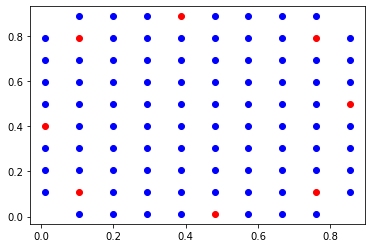

In [9]:
if training_layout == 1:
    tokens = ["x1_y5", "x2_y2", "x2_y9", "x5_y10", "x6_y1", "x9_y2", "x9_y9", "x10_y6"] # Layout 1
elif training_layout == 2:
    tokens = ["x2_y2", "x2_y9", "x4_y4", "x4_y7", "x7_y4", "x7_y7", "x9_y2", "x9_y9"] # Layout 2
elif training_layout == 3:
    tokens = ["x1_y4", "x1_y7", "x4_y1", "x4_y4", "x4_y7", "x4_y10", "x7_y1", "x7_y4", "x7_y7", "x7_y10", "x10_y4", "x10_y7"] # Layout 3
elif training_layout == 4:
    tokens = ["x1_y5", "x2_y2", "x2_y9", "x4_y4", "x4_y7", "x5_y10", "x6_y1", "x7_y4", "x7_y7", "x9_y2", "x9_y9", "x10_y6"] # Arrangement 4
elif training_layout == 5:
    tokens = ["x1_y4", "x2_y2", "x1_y7", "x2_y9", "x4_y1", "x4_y4", "x4_y7", "x4_y10", "x7_y1", "x7_y4", "x7_y7", "x7_y10", "x9_y2", "x9_y9", "x10_y4", "x10_y7"] # Layout 5
elif training_layout == 6:
    tokens = ["x1_y4", "x2_y2", "x1_y7", "x2_y9", "x4_y1", "x5_y7", "x6_y4", "x3_y4", "x3_y7", "x4_y10", "x7_y1", "x8_y4", "x8_y7", "x7_y10", "x9_y2", "x9_y9", "x10_y4", "x10_y7"] # Layout 6


training_group, test_group = create_custom_training_set (srs_path = train_set_path, tokens = tokens, specific = True)

plot_custom_training_set (training_group, test_group)

In [10]:
train_X, train_Y = create_labeled_data(srs_path = train_set_path, label_type = model_type, category_group = training_group)
test_X, test_Y = create_labeled_data(srs_path = test_set_path, label_type = model_type, category_group = test_group)
val_X, val_Y = create_labeled_data(srs_path = validation_set_path, label_type = model_type)

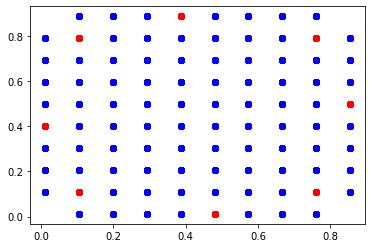

In [11]:
plt.scatter(val_Y[:,0], val_Y[:,1], c='b')
plt.scatter(train_Y[:,0], train_Y[:,1], c='r')
plt.show()

In [23]:
model = CNN_regression(input_shape = (size[1], size[0], channel_sensors))
model.summary()
model.save(model_file_name)

tf.keras.utils.plot_model(model, model_file_name + ".png", show_shapes=True, show_layer_names=True, expand_nested=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 8, 16, 40)         2200      
_________________________________________________________________
batch_normalization_3 (Batch (None, 8, 16, 40)         160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 8, 40)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 4, 8, 40)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 8, 60)          21660     
_________________________________________________________________
batch_normalization_4 (Batch (None, 4, 8, 60)          240       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 2, 4, 60)         

In [ ]:
train_model(model_file_name = model_file_name, target_mse = target_mse, accuracy_threshold = accuracy_threshold)

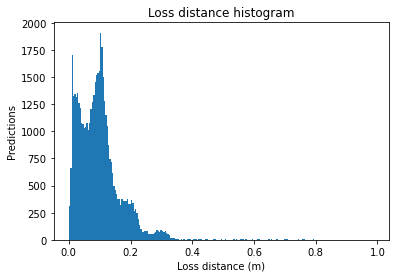

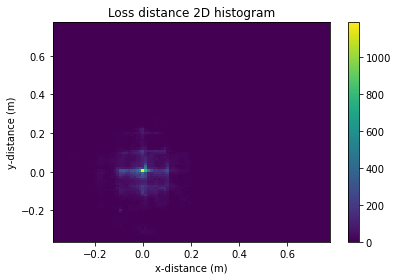

Sensors = 6
MSE = 0.014868516605560558
Ave error = 0.09767599672679461
Max error = 0.9863442548398174
Accuracy = 0.833875


In [28]:
model = load_model(model_file_name)

mse, ave_error, max_error, accuracy = evaluate_regression(model = model, val_X = val_X, val_Y = val_Y, accuracy_threshold = accuracy_threshold, plot_histogram = True, file_name = "float32")

print("Sensors = {}".format(channel_sensors))
print("MSE = {}".format(mse))
print("Ave error = {}".format(ave_error))
print("Max error = {}".format(max_error))
print("Accuracy = {}".format(accuracy))

In [13]:
convert_to_TF_Lite_float32(model_file_name)

2022-03-13 16:01:41.177148: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmpgilo_ulv/assets
model_8x16x6.h5 has been converted to TF Lite (float32).


2022-03-13 16:01:42.486959: I tensorflow/core/grappler/devices.cc:78] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2022-03-13 16:01:42.487428: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2022-03-13 16:01:42.490622: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:928] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.002ms.
  function_optimizer: function_optimizer did nothing. time = 0.001ms.

2022-03-13 16:01:42.563955: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:316] Ignored output_format.
2022-03-13 16:01:42.564037: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:319] Ignored drop_control_dependency.
2022-03-13 16:01:42.595720: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. T

In [14]:
convert_to_TF_Lite_int8(model_file_name = model_file_name, val_X = val_X)

INFO:tensorflow:Assets written to: /tmp/tmpmh58csae/assets


INFO:tensorflow:Assets written to: /tmp/tmpmh58csae/assets
2022-03-13 16:01:47.153663: I tensorflow/core/grappler/devices.cc:78] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2022-03-13 16:01:47.153830: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2022-03-13 16:01:47.155308: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:928] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.002ms.
  function_optimizer: function_optimizer did nothing. time = 0ms.

2022-03-13 16:01:47.218951: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:316] Ignored output_format.
2022-03-13 16:01:47.218983: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:319] Ignored drop_control_dependency.


model_8x16x6.h5 has been converted to TF Lite (int8).


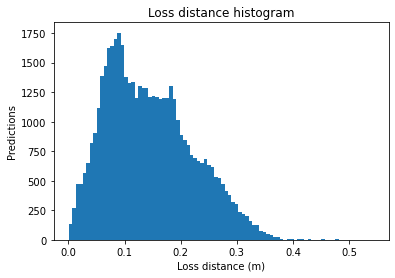

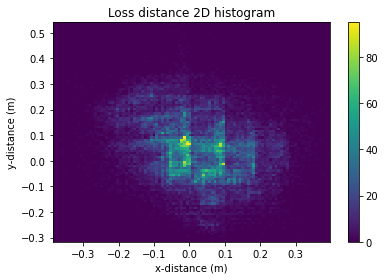

Sensors = 6
MSE = 0.026647929399414058
Ave error = 0.14397648498440627
Max error = 0.5431318440664867
Accuracy = 0.5665208333333334


In [15]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path = model_file_name + "_i8" + '.tflite')
interpreter.allocate_tensors()

mse_lite, ave_error_lite, max_error_lite, accuracy_lite = evaluate_regression_TF_Lite(interpreter = interpreter, val_X = val_X, val_Y = val_Y, accuracy_threshold = accuracy_threshold, plot_histogram = True, file_name="int8")


print("Sensors = {}".format(channel_sensors))
print("MSE = {}".format(mse_lite))
print("Ave error = {}".format(ave_error_lite))
print("Max error = {}".format(max_error_lite))
print("Accuracy = {}".format(accuracy_lite))

In [ ]:
tuning_parameters = {
    "model_file_name" : model_file_name,
    "tune" : 2,
    "exponent_bit_width" : 4,
    "mantissa_bit_width" : 0,
    "train_set_x" : train_X,
    "train_set_y" : train_Y,
    "test_set_x" : test_X,
    "test_set_y" : test_Y,
    "val_set_x" : val_X,
    "val_set_y" : val_Y,
    "accuracy_threshold" : accuracy_threshold,
    "tuning_epochs" : 4
    }

custom_floating_point_tuning(tuning_parameters)

In [ ]:
model = load_model(model_file_name)

#print_model (model)

mse, ave_error, max_error, accuracy = evaluate_regression(model = model, val_X = val_X, val_Y = val_Y, accuracy_threshold = accuracy_threshold, plot_histogram = True, file_name="(E4M0)")

print("Sensors = {}".format(channel_sensors))
print("MSE = {}".format(mse))
print("Ave error = {}".format(ave_error))
print("Max error = {}".format(max_error))
print("Accuracy = {}".format(accuracy))

In [31]:
convert_to_TF_Lite_int8(model_file_name = model_file_name, val_X = val_X)

INFO:tensorflow:Assets written to: /tmp/tmpqiqc9pn3/assets


INFO:tensorflow:Assets written to: /tmp/tmpqiqc9pn3/assets
2022-03-13 19:43:00.379245: I tensorflow/core/grappler/devices.cc:78] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2022-03-13 19:43:00.379600: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2022-03-13 19:43:00.391965: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:928] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.005ms.
  function_optimizer: function_optimizer did nothing. time = 0ms.

2022-03-13 19:43:00.508598: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:316] Ignored output_format.
2022-03-13 19:43:00.508633: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:319] Ignored drop_control_dependency.


model_8x16x6.h5 has been converted to TF Lite (int8).


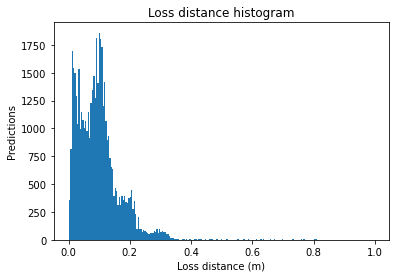

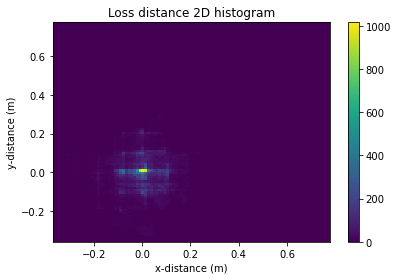

Sensors = 6
MSE = 0.015124204445190432
Ave error = 0.09815830608427871
Max error = 0.9939536450340944
Accuracy = 0.8312083333333333


In [32]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path = model_file_name + "_i8" + '.tflite')
interpreter.allocate_tensors()

mse_lite, ave_error_lite, max_error_lite, accuracy_lite = evaluate_regression_TF_Lite(interpreter = interpreter, val_X = val_X, val_Y = val_Y, accuracy_threshold = accuracy_threshold, plot_histogram = True, file_name="int8(E4M0)")


print("Sensors = {}".format(channel_sensors))
print("MSE = {}".format(mse_lite))
print("Ave error = {}".format(ave_error_lite))
print("Max error = {}".format(max_error_lite))
print("Accuracy = {}".format(accuracy_lite))

Input sample = validation_set/P_x3_y2/sample_2251.npy, model prediction = [[0.29023677 0.00535372]]


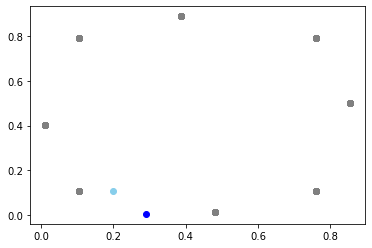

In [35]:
category_name = "P_x3_y2"

file = validation_set_path + "/" + category_name + "/sample_2251.npy"

sample = np.load(file)
sample = sample.astype('float32') / 255.0
sample = np.expand_dims(sample, axis=0)

model = load_model(model_file_name)

model_output = model.predict(sample)

if model_type == "regression":
    print("Input sample = {}, model prediction = {}".format(file, model_output))
else:
    print("Input sample = {}, model prediction = {}".format(file, get_category(model_output)))

tensor = np.zeros((1, 2))

x_i = int(category_name.split("_")[1].split("x")[1]) - 1
y_i = int(category_name.split("_")[2].split("y")[1]) - 1

x_pos = 0.0935 * x_i + 0.012
y_pos = 0.0973 * y_i + 0.012
tensor[0,:] = [x_pos, y_pos]

plt.scatter(train_Y[:,0], train_Y[:,1], c='gray')
plt.scatter(tensor[:,0], tensor[:,1], c='skyblue')
plt.scatter(model_output[:,0], model_output[:,1], c='blue')
plt.show()

Grid (sample = 280, channels = 3)


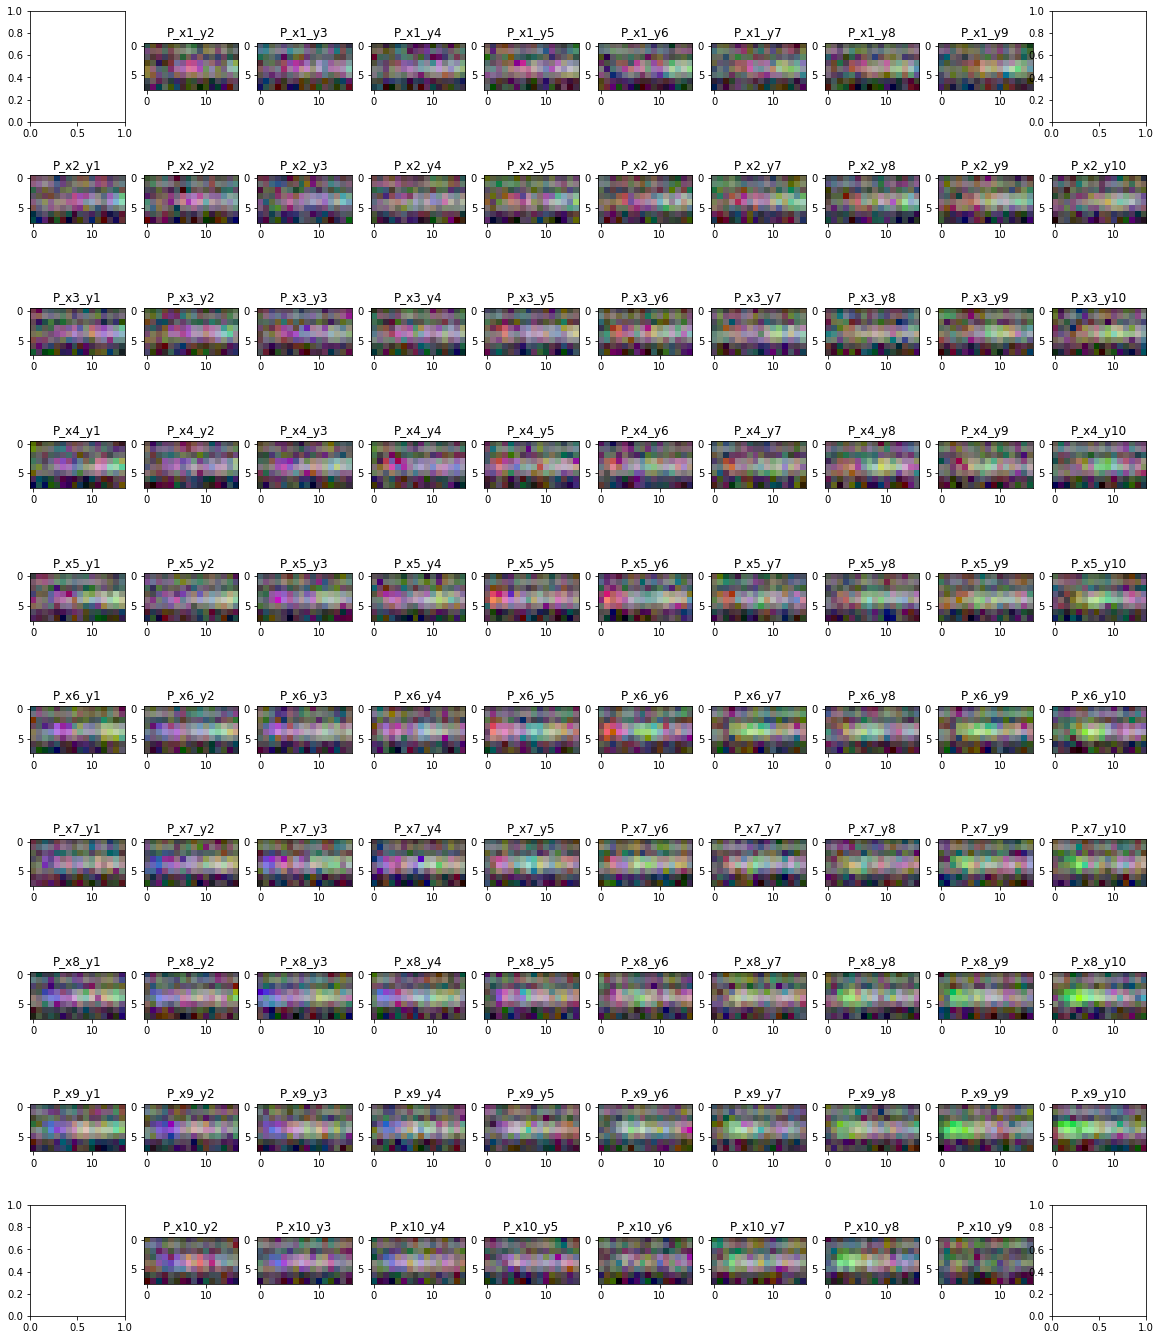

In [ ]:
show_grid(sample = 280, channels = 3, crop_area = crop_area, size = size)

Sample = 280, class = P_x10_y9


/tmp/ipykernel_138036/1394040217.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


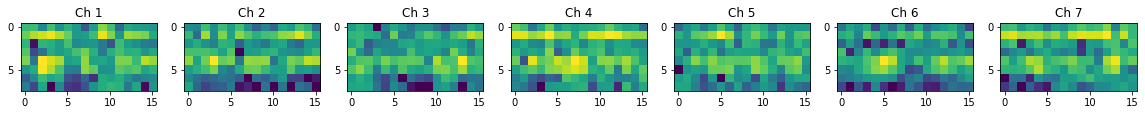

In [ ]:
show_sample(class_name = "P_x10_y9", sample = 280, crop_area = crop_area, size = size)